In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize, approx_fprime
from joblib import Parallel, delayed

Capture hides output

In [2]:
%%capture
# %run cowling_approximation2.ipynb
# %run cowling_approximation2_invert_dedp.ipynb
# %run cowling_approximation.ipynb
# %run cowling_approximation2_invert_dedp_extrapolate.ipynb
# %run cowling_approximation3.ipynb
# %run cowling_approximation3_wu_equations.ipynb
# %run cowling_approximation4.ipynb
# %run cowling_approximation5.ipynb
%run cowling_approximation6.ipynb

In [3]:
def process(k):
    df = pd.read_csv(path)
    e, p = df_to_ep(df)
    EOS = get_ep(e, p)
    
    # Initial Conditions
    km2cm = 1e5
    r_i = 1
    p0 = p[k]
    e0 = EOS(p0)
    p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
    e_c = EOS(p_c)
    m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
    omega = 2e3*(2*np.pi) #Arbitrary guess
    l=2
    v0 = -1 # Two step integration optimization: similar to phi previously.
    W0 = 1
    U0 = W0/(l * np.exp(v0))
    init_VEC = [p_c, m0, v0, W0, U0]

    # Integrate
    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min,omega, l = l)

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]

    schild = (1-2*G*m_R/(c**2*r_R))
    interior = np.exp(v_R)
    # Computer new v0, W0, U0
    v_ext = np.log(schild) #At surface
    v_int = v_R #At surface
    delta_v = v_int - v_ext
    v0 =  v0 - delta_v
    W0 = 1
    U0 = W0/(l * np.exp(v0))
    init_VEC = [p_c, m0, v0, W0, U0]

    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega, l = l)

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]

    schild = (1-2*G*m_R/(c**2*r_R))
    interior = np.exp(v_R)
    
    def minimize_boundary_mass_plot(params, p = p, EOS = EOS):
        # Repeat integration

        omega = params

        # Integrate
        p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega, l = l)

        max_idx = np.argmax(m)
        m_R = m.max() # In units of msun
        r_R = r_arr[max_idx] # In units of km
        p_R = p[max_idx] #cgs
        ec_R = EOS(p_R) #cgs
        u_R = u[max_idx] #cgs
        v_R = v[max_idx]
        w_R = w[max_idx] 

        loss = np.log10(abs(boundary_wu(r_R, m_R, omega, w_R, u_R)))
        return loss

    omega_guess = 0.1e3*(2*np.pi)
    init_guess = [omega_guess]
    res = minimize(minimize_boundary_mass_plot, x0 = init_guess, 
                   method='Nelder-Mead', 
                   options = {"disp": False, "maxiter":15},
                   tol = 1)

    omg = res.x[0]
    f = omg/(2*np.pi)
    return f, m_R, r_R, k

In [4]:
f_mode_list = []
mass_list = []
radius_list = []

if path == "eos_data/nl3cr_short.csv":
    print("EOS: NL3CR (Short)")
    ind_start = -4
    ind_stop = -1180
    jump = 20 # Default should be 1 for small EOS data
    
if path == "eos_data/nl3cr.csv" :
    print("EOS: NL3CR (Full)")
    ind_start = -2
    ind_stop = -1140
    jump = 20 # Default should be 1 for small EOS data
    
if (path == "eos_data/sly230a_short.csv") \
    or (path =="eos_data/sly230a.csv"):
    print("EOS: SLY230A (Full)")
    ind_start = -10
    ind_stop = -120
    jump = 5 # Default should be 1 for small EOS data
    
if path == "eos_data/sly_short.csv":
    print("EOS: SLY4 (Short)")
    ind_start = -2
    ind_stop = -28
    jump = 1 # Default should be 1 for small EOS data
    
if path == "eos_data/sly.csv": 
    print("EOS: SLY4 (Full)")
    ind_start = -2
    ind_stop = -35
    jump = 1 # Default should be 1 for small EOS data

if path == "2205.02081/SLY4.csv": 
    print("EOS: SLY4 (arXiv 2205.02081)")
    ind_start = -1
    ind_stop = -1200
    jump = 20 # Default should be 1 for small EOS data
    
path2 = None
# path2 = "polytrope"
    
if path2 == "polytrope":
    ind_start = -2
    ind_stop = -200
    jump = 5
    
vals = range(ind_stop, ind_start+1, 1)[::-jump]

results = Parallel(n_jobs=-2, 
                   verbose=0,
                   max_nbytes='8M')(delayed(process)(k) for k in tqdm(vals))

EOS: SLY4 (arXiv 2205.02081)


In [5]:
mass_arr = np.array(results).T[1]
f_mode_arr = np.array(np.array(results).T[0])
radius_arr = np.array(results).T[2]
idx_arr = np.array(results).T[3]
hz2khz = 1e-3

In [6]:
mass_arr

array([3.91974170e+33, 4.07458620e+33, 3.99485296e+33, 3.66407220e+33,
       3.10979631e+33, 2.42331136e+33, 1.73274719e+33, 1.14719073e+33,
       7.17970358e+32, 4.40362807e+32, 2.79947057e+32, 1.97905447e+32,
       1.55073678e+32, 1.50903494e+32, 1.49251820e+32, 1.47766365e+32,
       1.46320187e+32, 1.44862597e+32, 1.43357530e+32, 1.41777264e+32,
       1.40103811e+32, 1.38286809e+32, 1.36307255e+32, 1.34152012e+32,
       1.31812880e+32, 1.29287892e+32, 1.26578496e+32, 1.23690322e+32,
       1.20632247e+32, 1.17415868e+32, 1.14054894e+32, 1.10565733e+32,
       1.06965891e+32, 1.03274646e+32, 9.95120691e+31, 9.56941801e+31,
       9.18458899e+31, 8.79842511e+31, 8.41275688e+31, 7.72583703e+31,
       5.93081415e+31, 4.39907652e+31, 3.18102299e+31, 2.26551786e+31,
       1.61741198e+31, 1.23729177e+31, 7.94875179e+30, 5.07498204e+30,
       3.22689630e+30, 2.04648395e+30, 1.29568820e+30, 8.19328524e+29,
       5.17709658e+29, 3.26954847e+29, 2.06414106e+29, 1.30285726e+29,
      

In [7]:
max_idx = mass_arr.argmax()
# idx_arr[(np.abs(mass_arr/msun - 1.4)).argmin()]

In [8]:
mass_arr = mass_arr[max_idx:]
f_mode_arr = f_mode_arr[max_idx:]
radius_arr = radius_arr[max_idx:]

In [9]:
max_idx_new = mass_arr.argmax()

print(f"M_max = {mass_arr[max_idx_new]/msun}")
print(f"R_max = {radius_arr[max_idx_new]/km2cm}")
print(f"f_max = {f_mode_arr[max_idx_new]}")

print()
solar_idx = (np.abs(mass_arr/msun - 1.4)).argmin()
print(f"M_1.4 = {mass_arr[solar_idx]/msun}")
print(f"R_1.4 = {radius_arr[solar_idx]/km2cm}")
print(f"f_1.4 = {f_mode_arr[solar_idx]}")

M_max = 2.049106196344392
R_max = 9.85001
f_max = 2355.0

M_1.4 = 1.563914118318502
R_1.4 = 11.57001
f_1.4 = 2015.0


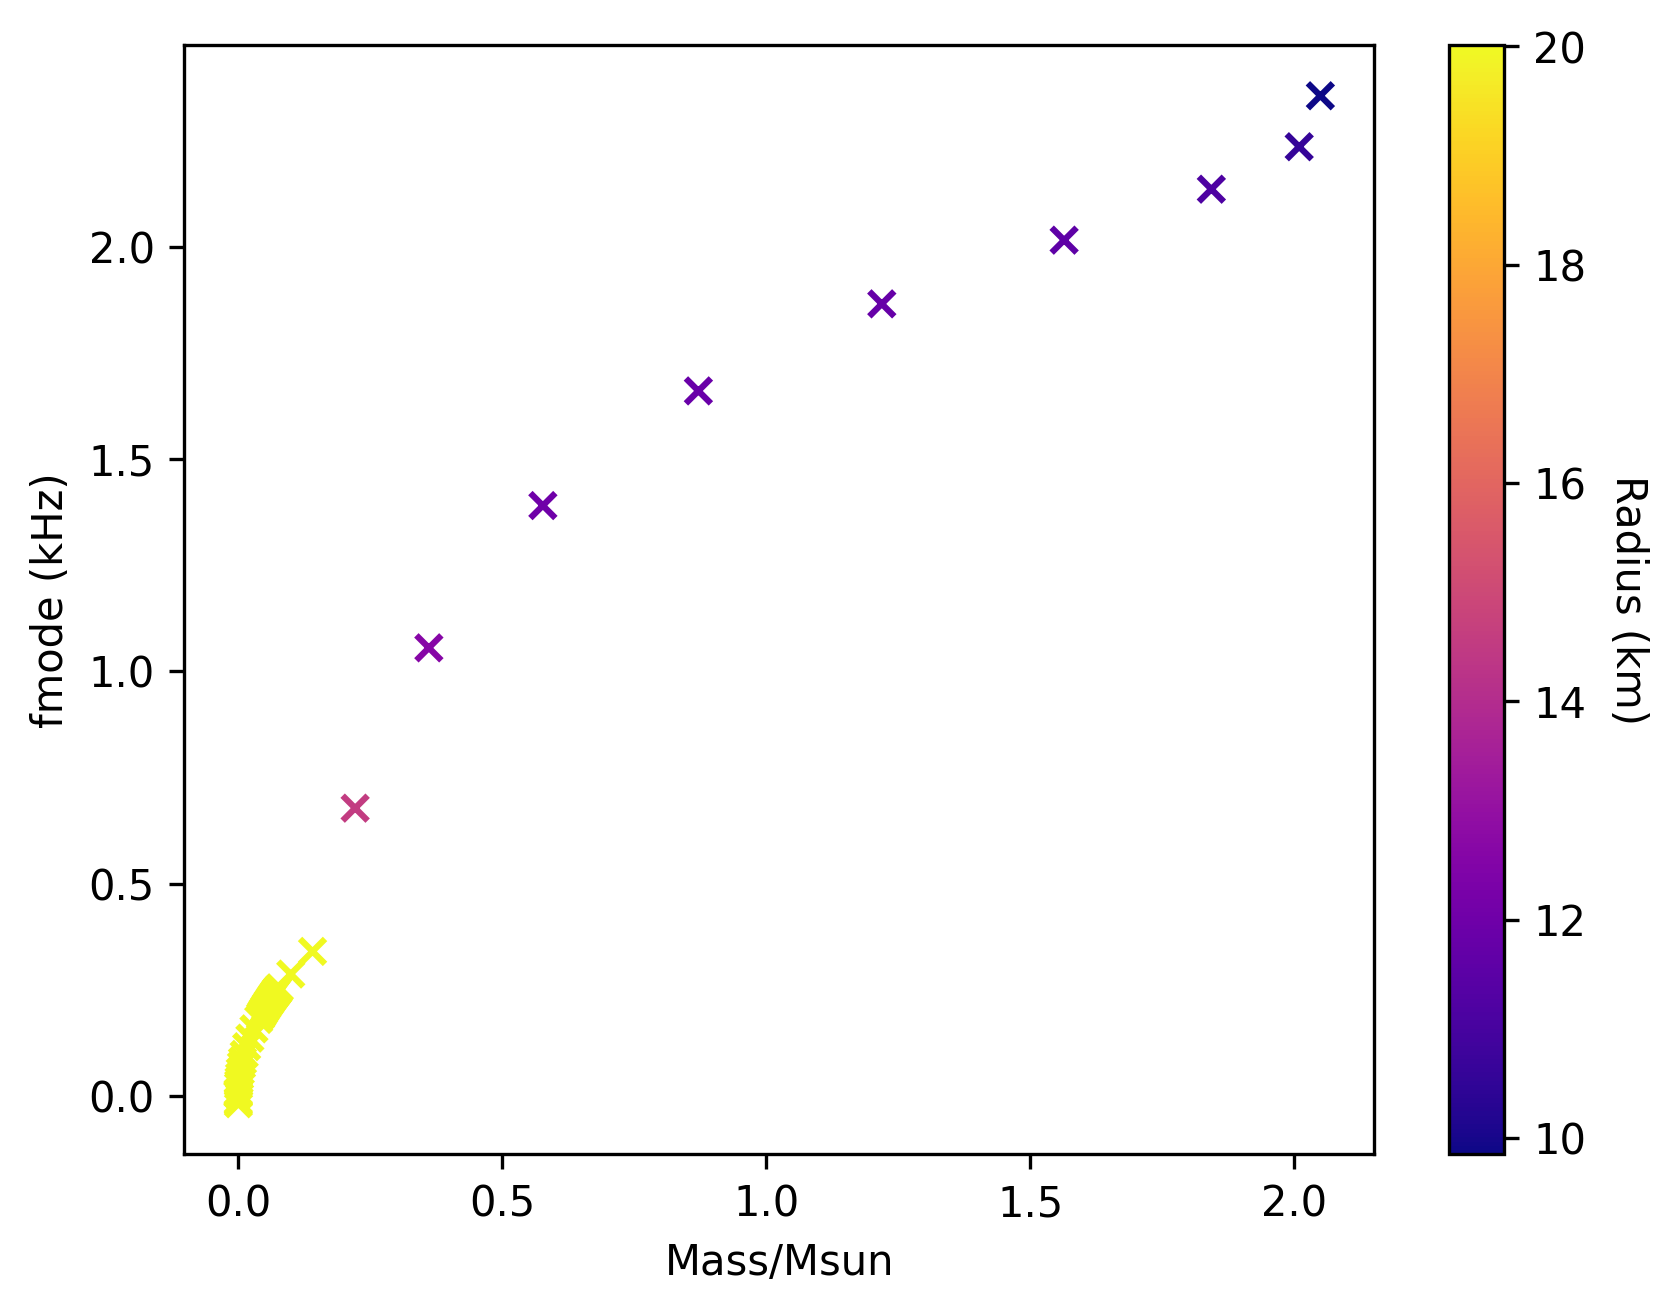

In [15]:
# mass_arr = np.array(mass_list)
# f_mode_arr = np.array(f_mode_list)
# radius_arr = np.array(radius_list)
# hz2khz = 1e-3

plt.figure(dpi = 300)
plt.tight_layout()
plt.scatter(mass_arr/msun, f_mode_arr*hz2khz, c = radius_arr/km2cm, marker = "x", 
            cmap = "plasma")
plt.xlabel("Mass/Msun")
plt.ylabel("fmode (kHz)")
cbar = plt.colorbar()
cbar.set_label('Radius (km)', rotation=-90, labelpad=15)
# utkarshGrid()
# plt.xlim(1, 2.5)
# plt.ylim(1.5, 3.5)
plt.show()

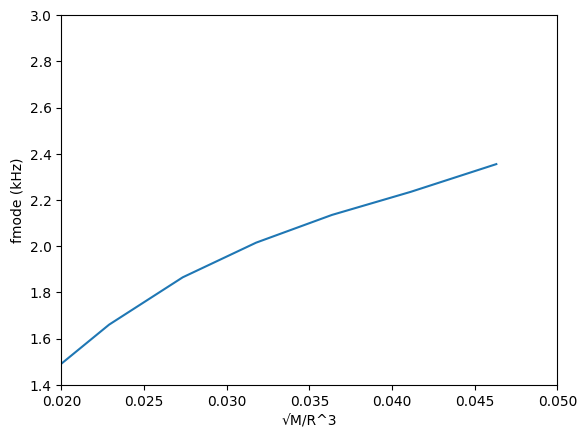

In [11]:
plt.plot(np.sqrt((mass_arr/msun)/((radius_arr/km2cm)**3)), f_mode_arr*hz2khz)
plt.xlabel("√M/R^3")
plt.ylabel("fmode (kHz)")
plt.xlim(0.02, 0.05)
plt.ylim(1.4, 3)
plt.show()

In [12]:
# plt.plot(np.sqrt((mass_arr/(1.4*msun))/((radius_arr/(10*km2cm))**3)), f_mode_arr*hz2khz)
# plt.ylabel("f(khz)")
# plt.show()

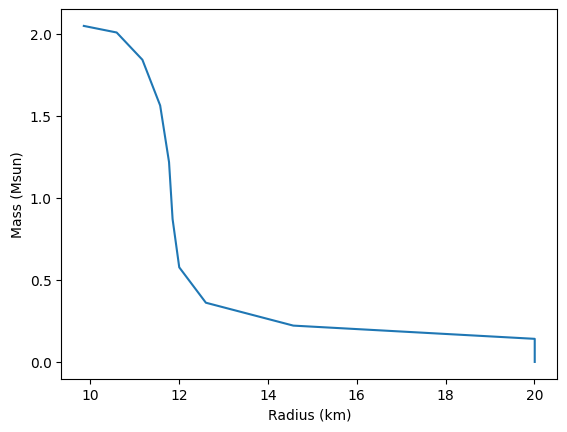

In [13]:
plt.plot(radius_arr/km2cm, mass_arr/msun)
plt.xlabel("Radius (km)")
plt.ylabel("Mass (Msun)")
plt.show()

In [14]:
# np.savetxt("mr_sly.csv", np.array([radius_arr, mass_arr]).T)